# Game-shop

**Описание проекта**

Используя исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы, были выявлены закономерности, определяющие успешность игр, и сформирован прогноз популярности игровых платформ и жанров на релевантный период.

**План проекта:**
- Изучение и предобработка данных
- Расчет суммарного числа продаж в разрезе регионов
- Проведем EDA
- Определим актуальный период для анализа
- Составим портрет пользователя для каждого региона:
    - определим cамые популярные платформы (топ-5)
    - определим cамые популярные жанры (топ-5)
    - оценим влияние рейтинга ESRB на продажи
- Проверим гипотезы:
    - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    - cредние пользовательские рейтинги жанров Action и Sports разные.


### <a id="step1">Шаг 1. Обзор данных

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math

pd.options.display.float_format = '{:.3f}'.format

### Инсайты:

1. Полных дубликатов нет
2. `Year_of_Release` нужно привести к типу int
3. Больше всего пропусков и филлеров пропусков в столбцах `Critic_Score`, `User_Score`, `Rating`. Можно сделать предположение, что данные пропуски обусловлены отсутствием рейтинга среди критиков и пользователей, в связи с жанром игры (инди-игры) и качеством игр (не AAA-проекты), либо недавним релизом игры
4. Также есть пропуски в столбцах `Name`, `Platform`, `Year_of_Release`, `Genre` - возможно это человеческий фактор заполнения данных, так как пропусков в столбцах по данным о продажах нет.

### <a id="step2">Шаг 2. Предобработка данных

In [10]:
# Изменим название колонок на нижний регистр

columns_list = df_game.columns.str.lower() #  список названий столбцов с нижним регистром
df_game.columns = columns_list
df_game.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11769,World Tour Soccer 06,PSP,2006.000,Sports,0.070,0.000,0.000,0.010,72.000,tbd,E


In [11]:
# Сделаем 2 списка с категориальными и количественными переменными

cat_features = ['name', 'platform', 'genre', 'rating']
num_features= [
    'year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']

In [12]:
#  Изучим пропуски в категориальных признаках

for cat_feature in cat_features:
    cat_na = df_game[cat_feature].isna().sum()
    print(cat_feature, 'пропусков', cat_na)

name пропусков 2
platform пропусков 0
genre пропусков 2
rating пропусков 6766


In [13]:
# Посмотрим нулевые строки в столбцах с именем и платформой

null_name = df_game.loc[(df_game['name'].isna()) | (df_game['genre'].isna())]
null_name.index

Int64Index([659, 14244], dtype='int64')

In [14]:
# так как в данных строках нет большей части информации - удаляем данные строки

df_game.drop(index = null_name.index, inplace = True)

In [15]:
# Посмотрим столбец `rating`

df_game['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [16]:
df_game['rating'].isna().sum()

6764

#### Заполнить пропуски  в рейтинге игр довольно сложно, на данном этапе пропуски обрабатывать не будем

In [17]:
# Проверим есть ли повторы в именах игр и платформах

df_game.duplicated(['name', 'platform']).sum()

4

In [18]:
# Посмотрим на данные повторы

df_game.loc[df_game.duplicated(['name', 'platform'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.000,Sports,2.110,0.220,0.000,0.230,83.000,5.5,E
1190,Need for Speed: Most Wanted,X360,2012.000,Racing,0.620,0.780,0.010,0.150,83.000,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.000,Racing,1.000,0.130,0.020,0.100,83.000,8.5,T
1745,Sonic the Hedgehog,PS3,2006.000,Platform,0.410,0.060,0.040,0.660,43.000,4.1,E10+
4127,Sonic the Hedgehog,PS3,nan,Platform,0.000,0.480,0.000,0.000,43.000,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.000,Racing,0.020,0.230,0.000,0.040,82.000,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.000,Racing,0.000,0.060,0.000,0.020,82.000,8.5,T
16230,Madden NFL 13,PS3,2012.000,Sports,0.000,0.010,0.000,0.000,83.000,5.5,E


#### По игре Need for Speed: Most Wanted в 2012 году было выпущен remastered, тогда как по Sonic the Hedgehog и Madden NFL 13	необходимо объединить строки, иначе будут утеряны данные о продажах в регионах

In [19]:
# Создаем DataFrame с дубликатами и анализируем данные

repeated_game = df_game.loc[
    (df_game.duplicated(['name', 'platform'], keep=False)) & (df_game['name'] != 'Need for Speed: Most Wanted')].reset_index()

repeated_game 

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,604,Madden NFL 13,PS3,2012.000,Sports,2.110,0.220,0.000,0.230,83.000,5.5,E
1,1745,Sonic the Hedgehog,PS3,2006.000,Platform,0.410,0.060,0.040,0.660,43.000,4.1,E10+
2,4127,Sonic the Hedgehog,PS3,nan,Platform,0.000,0.480,0.000,0.000,43.000,4.1,E10+
3,16230,Madden NFL 13,PS3,2012.000,Sports,0.000,0.010,0.000,0.000,83.000,5.5,E


In [20]:
# Cоздаем сводную таблицу с аккумулированными данными по продажам

repeated_game_pivot = repeated_game.pivot_table(
    index = 'name', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc = 'sum')
repeated_game_pivot

,eu_sales,jp_sales,na_sales,other_sales
name,,,,
Madden NFL 13,0.230,0.000,2.110,0.230
Sonic the Hedgehog,0.540,0.040,0.410,0.660


In [21]:
repeated_game_index = [(604, 'Madden NFL 13'), (1745, 'Sonic the Hedgehog')] #  создаем список кортежей
repeated_game_pivot_col_list = repeated_game_pivot.columns.tolist() #  список наименований колонок

# Цикл для замены значений

for index, game_name in repeated_game_index:
    for col in repeated_game_pivot_col_list:
        df_game.loc[index, col] = repeated_game_pivot.loc[game_name][col]

In [22]:
df_game.drop(index = [4127, 16230], inplace = True) # удаляем строки

In [23]:
# Проверяем, что дубликаты строк удалены

df_game.loc[df_game.duplicated(['name', 'platform'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012.000,Racing,0.620,0.780,0.010,0.150,83.000,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.000,Racing,1.000,0.130,0.020,0.100,83.000,8.5,T
5972,Need for Speed: Most Wanted,PC,2005.000,Racing,0.020,0.230,0.000,0.040,82.000,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.000,Racing,0.000,0.060,0.000,0.020,82.000,8.5,T


In [24]:
#  Изучим пропуски в количественных признаках

for num_feature in num_features:
    num_na = df_game[num_feature].isna().sum()
    print(num_feature, 'пропусков', num_na)

year_of_release пропусков 268
na_sales пропусков 0
eu_sales пропусков 0
jp_sales пропусков 0
other_sales пропусков 0
critic_score пропусков 8576
user_score пропусков 6699


In [25]:
# Приведем данные `year_of_release` к типу Int16, чтобы обработать пропуски

df_game['year_of_release'] = df_game['year_of_release'].astype('Int16')

df_game.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16601,The Land Before Time: Into the Mysterious Beyond,GBA,2006,Platform,0.010,0.000,0.000,0.000,nan,NaN,NaN
15544,Ten Pin Alley 2,Wii,2008,Sports,0.020,0.000,0.000,0.000,30.000,tbd,E
8168,Virtua Tennis,GBA,2002,Sports,0.130,0.050,0.000,0.000,83.000,tbd,E
13497,The King of Fighters 2002: Unlimited Match,PS2,2009,Fighting,0.000,0.000,0.040,0.000,nan,NaN,NaN
7843,God Eater Resurrection,PSV,2015,Action,0.000,0.000,0.190,0.000,nan,8.8,T


####  Пропуска в `year_of_release` (269 строк) заменим на 0, из некоторых игр можно взять год релиза из названия, но это трудоемко, и не всегда год в названии обозначает год релиза

In [26]:
df_game['year_of_release'].fillna(0)

0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16711, dtype: Int16

In [27]:
#  Рассмотрим столбец `user_score`

df_game['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.6       2
9.6       2
0.2       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

#### Значения tbd (to be done) могут означать, что рейтинг игры у пользователей еще не сформирован. Возможная причина: недавний релиз игры или оформленный предзаказ на еще невыпущенную игру. Заменим данные значения на NaN

In [28]:
df_game.loc[df_game['user_score'] == 'tbd'] = df_game.loc[df_game['user_score'] == 'tbd']['user_score'] = np.nan
df_game['user_score'].value_counts()

7.8    324
8      290
8.2    282
8.3    254
8.5    253
      ... 
9.6      2
0.5      2
0.2      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

In [29]:
# Заменим тип данных в столбце `user_score`

df_game['user_score'] = df_game['user_score'].astype('float64')

In [30]:
# Для последующего анализа приведем данные  в столбце `user_score` к 100-балльной шкале

df_game['user_score'] = df_game['user_score']*10

#### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [31]:
df_game['revenue'] = df_game.apply(
    lambda row: row['na_sales'] + row['eu_sales'] + row ['jp_sales'] + row['other_sales'], axis = 1)

In [32]:
df_game.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,revenue
9876,NaN,NaN,<NA>,NaN,nan,nan,nan,nan,nan,nan,NaN,nan
15277,Diabolik Lovers: More Blood,PSV,2015,Adventure,0.000,0.000,0.020,0.000,nan,nan,NaN,0.020
6984,Star Wars Jedi Knight II: Jedi Outcast,GC,2002,Shooter,0.180,0.050,0.000,0.010,75.000,78.000,T,0.240
10868,Super Robot Wars OG: The Moon Dwellers,PS4,2016,Misc,0.000,0.000,0.090,0.000,nan,nan,NaN,0.090
9585,NaN,NaN,<NA>,NaN,nan,nan,nan,nan,nan,nan,NaN,nan


In [33]:
df_game.sort_values(by = 'revenue')
df_game.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,revenue
0,Wii Sports,Wii,2006,Sports,41.360,28.960,3.770,8.450,76.000,80.000,E,82.540
1,Super Mario Bros.,NES,1985,Platform,29.080,3.580,6.810,0.770,nan,nan,NaN,40.240
2,Mario Kart Wii,Wii,2008,Racing,15.680,12.760,3.790,3.290,82.000,83.000,E,35.520
3,Wii Sports Resort,Wii,2009,Sports,15.610,10.930,3.280,2.950,80.000,80.000,E,32.770
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270,8.890,10.220,1.000,nan,nan,NaN,31.380


In [34]:
df_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14287 non-null  object 
 1   platform         14287 non-null  object 
 2   year_of_release  14067 non-null  Int16  
 3   genre            14287 non-null  object 
 4   na_sales         14287 non-null  float64
 5   eu_sales         14287 non-null  float64
 6   jp_sales         14287 non-null  float64
 7   other_sales      14287 non-null  float64
 8   critic_score     7053 non-null   float64
 9   user_score       7588 non-null   float64
 10  rating           7573 non-null   object 
 11  revenue          14287 non-null  float64
dtypes: Int16(1), float64(7), object(4)
memory usage: 1.6+ MB


### Выводы по предобработке данных:
1. Пропуски в столбцах `rating` и `year_of_release` заполнить практически невозможно
2. Пропуски в столбца с рейтингом означают, что данные игры были не оценены, в столбце `user_score` значения tbd были заменены на NaN
3. Датасет содержит информацию о продажах начиная с 1980 года по 2016 год. 
4. Самая популярная игра "Wii Sports" выручка = 82,5 миллиона, когда топ-2 Super Mario Bros. показывает выручку в 2 раза меньше - 40,2 млн долларов
5. Отработаны дублирующие строки игры Soniс и Madden NFL 13, аккумулированы данные по продажам по регионам

### <a id="step3">Шаг 3. Проведем исследовательский анализ данных

#### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [35]:
df_game.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     288
1998     379
1999     330
2000     307
2001     400
2002     637
2003     680
2004     655
2005     818
2006     882
2007    1005
2008    1101
2009    1021
2010     924
2011     919
2012     628
2013     529
2014     560
2015     568
2016     468
Name: name, dtype: int64

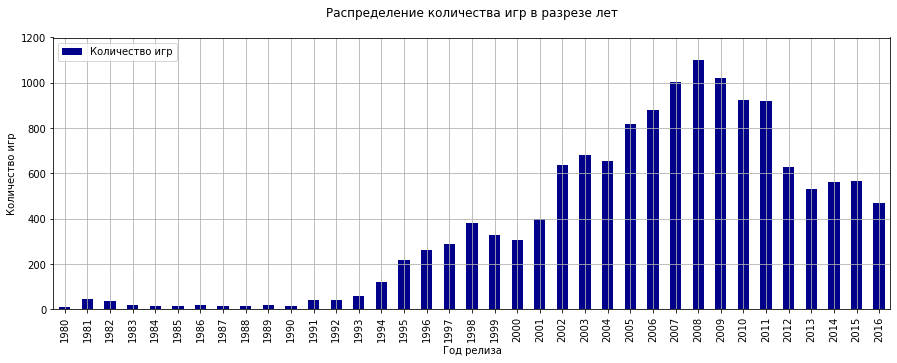

In [36]:
df_game.groupby('year_of_release')['name'].count().plot(
    kind = 'bar',
    grid = True, 
    legend = True, 
    color = 'darkblue',
    linewidth = 3, 
    label = 'Количество игр',
    figsize = [15,5]
)

plt.title('Распределение количества игр в разрезе лет' + '\n')
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.legend(loc = 'upper left')
plt.ylim(0,1200)
plt.show()

Игр до 1995 года мало - менее 200 изданий в год.  Нужно не учитвать данные ранее 1995 года - непрезентативная выборка. Так как нам необходимо учитывать актуальный период для формирования прогноза на валидных данных, учитывая текущие тенденции на рынке игр. Самым оптимальным выглядит взять данные с 2013 года, что позволит исключить пик в 2008 году, который могут исказить данные. 
Пик в 2008 года обусловлен качественным скачком в gamedev индустрии 

####  Посмотрим, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [37]:
# Посмотрим топ-10 платформ по суммарной выручке

game_top_10 = df_game.groupby('platform')['revenue'].sum().sort_values(ascending = False).head(10)
game_top_10

platform
PS2    1191.930
X360    958.840
PS3     929.400
Wii     807.140
PS      717.240
DS      657.000
PS4     314.000
PSP     277.120
GBA     265.920
PC      256.010
Name: revenue, dtype: float64

In [38]:
# Сделаем список top-10 платорм для дальнейшего построения графиков

game_top_10_list = game_top_10.index.tolist()
game_top_10_list

['PS2', 'X360', 'PS3', 'Wii', 'PS', 'DS', 'PS4', 'PSP', 'GBA', 'PC']

In [39]:
# Сделаем срез по top-10 платформам

df_game_top_10 = df_game.query('platform in @game_top_10_list')
df_game_top_10['year_of_release'].value_counts()

2008    1099
2009    1021
2007     999
2010     924
2011     810
2006     804
2005     590
2012     454
2004     438
2002     398
2003     395
2001     324
2013     318
2014     298
2015     283
1998     256
2016     251
2000     207
1999     199
1997     193
1996     168
1995     101
1994      23
1992       5
1985       2
1988       1
Name: year_of_release, dtype: Int64

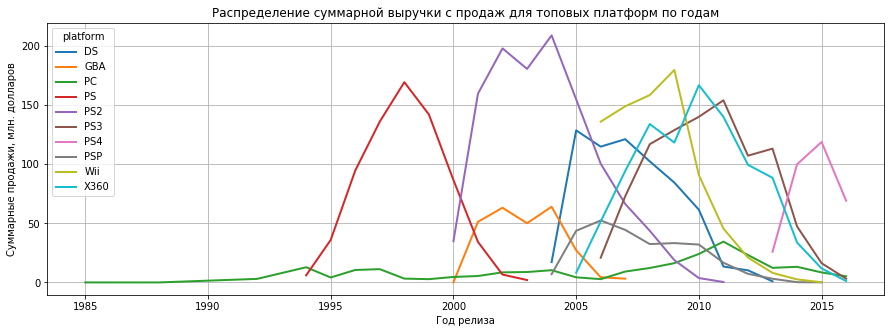

In [40]:
# Построим распределение количества игр на топовых платформах по годам

df_game_top_10.pivot_table(
    index = 'year_of_release', columns = 'platform', values = 'revenue',  aggfunc = 'sum').plot(
    grid = True, 
    linewidth = 2,
    label = 'Платформы',
    figsize = [15, 5],
    title = 'Распределение суммарной выручки с продаж для топовых платформ по годам')

plt.xlabel('Год релиза')
plt.ylabel('Cуммарные продажи, млн. долларов')
plt.show()

Средний год жизни платформы PS по получению выручки 10 лет, исключая PC. Среди пользователей PC развито "пиратство". Выручка игр на PC в среднем более стабильна, чем для игр других платформ.

Каждая часть PS актуальна в течение 10 лет, пока на смену не приходит консоль нового поколения. Посмотрим на распределения количества игр в top-10 платформах в разрезе годов.

В период с 2013 по 2015 год происходит спад, возможно это связано с набором популярности цифровых изданий, таких как Steam, PSN и возможно концом жизненного цикла популярных в то время платформ и набором популярности PS4.

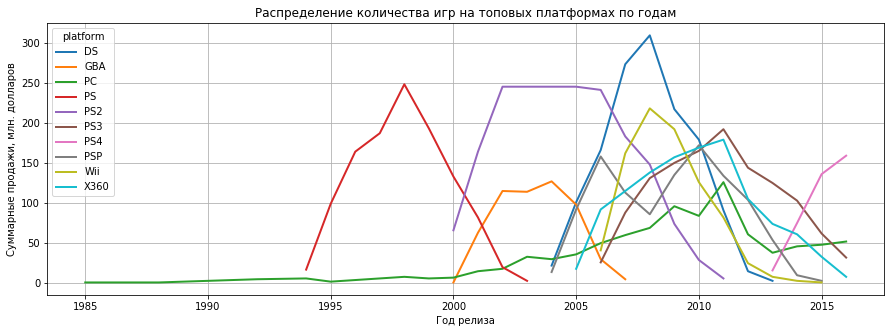

In [41]:
df_game_top_10.pivot_table(
    index = 'year_of_release', columns = 'platform', values = 'revenue',  aggfunc = 'count').plot(
    grid = True, 
    linewidth = 2,
    figsize = [15, 5],
    label = 'Платформы')

plt.title('Распределение количества игр на топовых платформах по годам')
plt.xlabel('Год релиза')
plt.ylabel('Cуммарные продажи, млн. долларов')
plt.show()

#### Примем актуальный период с 2013 по 2016 года, учитывая, что данные за 2016 год могут быть неполными, оставим все платформы

In [42]:
real_years = [2013, 2014, 2015, 2016]

df_game_real = df_game.query('year_of_release in @real_years')
df_game_real

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,revenue
16,Grand Theft Auto V,PS3,2013,Action,7.020,9.090,0.980,3.960,97.000,82.000,M,21.050
23,Grand Theft Auto V,X360,2013,Action,9.660,5.140,0.060,1.410,97.000,81.000,M,16.270
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.030,5.860,0.360,2.380,nan,nan,NaN,14.630
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.280,4.190,4.350,0.780,nan,nan,NaN,14.600
42,Grand Theft Auto V,PS4,2014,Action,3.960,6.310,0.380,1.970,97.000,83.000,M,12.620
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.000,0.000,0.010,0.000,nan,nan,NaN,0.010
16707,Aiyoku no Eustia,PSV,2014,Misc,0.000,0.000,0.010,0.000,nan,nan,NaN,0.010
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.000,0.000,0.010,0.000,nan,nan,NaN,0.010
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.000,0.000,0.010,0.000,nan,nan,NaN,0.010


#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

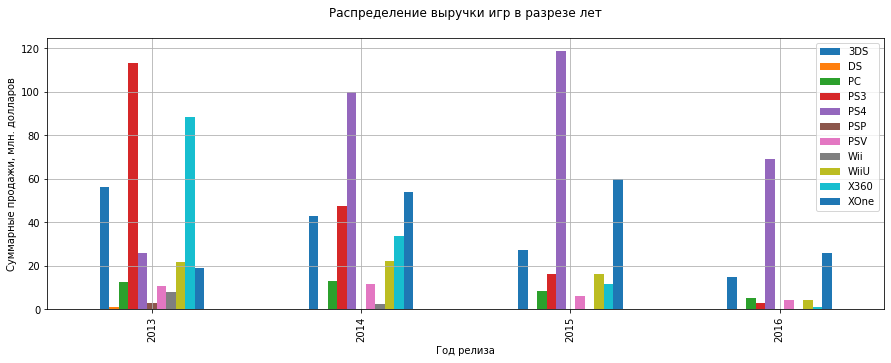

In [43]:
# Построим график прибыли по платформам в актуальном периоде


df_game_real_pivot = df_game_real.pivot_table(index = 'platform', columns = 'year_of_release', values = 'revenue', aggfunc = 'sum').T
df_game_real_pivot.plot(
    kind = 'bar',
    grid = True,
    figsize = [15,5])

plt.title('Распределение выручки игр в разрезе лет' + '\n')
plt.xlabel('Год релиза')
plt.ylabel('Cуммарные продажи, млн. долларов')
plt.legend(loc = 'upper right')
plt.show()

Исходя из данного графика можно исключить для дальнейшего анализа Nintendo DS, PSP, Wii, так как показатели продаж по ним крайне малы, и они всегда являлись нишевыми платформами. 

Всю линейку PS нужно оставить, так как на графиках виден спад продаж PS3 и увеличивающийся спрос на  PS4.  

Xbox360 - спрос падает, в связи с выходом консоли нового поколения XOne, но эти платформы важно учитывать. 

PC, PSV, WiiU показывают стаблильный уровень продаж в каждом году.

In [44]:
# Список самых востребованных платформ в анализируемый период 

df_game_real_list = df_game_real.groupby('platform')['revenue'].sum().sort_values(ascending = False).index.tolist()

for platform in ['PSP','DS','Wii']:
    df_game_real_list.remove(platform)

df_game_real_list

['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV']

In [45]:
# Делаем срез по востребованным платформам и суммарным продажам для дальнейшего построения boxplot

df_game_real_platform = df_game_real.query('platform in @df_game_real_list')

#### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

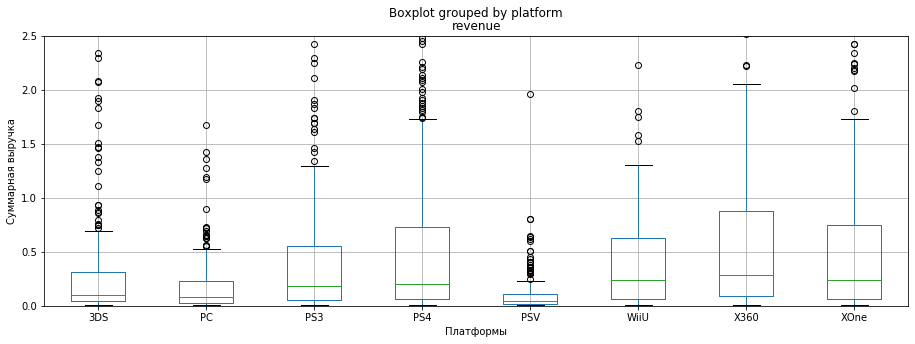

In [46]:
df_game_real_platform[['platform', 'revenue']].boxplot(by = 'platform', column = 'revenue', figsize = (15, 5))
plt.ylim(0, 2.5)

plt.xlabel('Платформы')
plt.ylabel('Суммарная выручка')
plt.show()

In [47]:
# Посмотрим на точные значения медианы

df_game_real_platform[['platform', 'revenue']].groupby('platform')['revenue'].median()

platform
3DS    0.100
PC     0.080
PS3    0.180
PS4    0.200
PSV    0.040
WiiU   0.240
X360   0.285
XOne   0.240
Name: revenue, dtype: float64

Медианные значения выручки по каждой из консоли приблизительно одинаковые, кроме портативных PSV, PС и 3DS. Несмотря на это, по всем платформам значения 75 перцентиля далеко от медианных значений, что может показывать наличия пиковых значения продаж у платформ. Распределение продаж по платформам не плавомерно даже у самых востребованных платформ.

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [48]:
# Оставим только нужные столбцы для анализа 

df_game_review = df_game_real_platform[['platform', 'critic_score', 'user_score','revenue']]

In [49]:
# Оставим только нужные столбцы для анализа без нулевых значений

df_game_good_review = df_game_review[
    (df_game_real_platform['critic_score'].notnull()) & (df_game_real_platform['user_score'].notnull())]

 **Добавим диаграмму зависимости отзывов пользователей и суммарной выручки за актуальный период по популярным платформам**

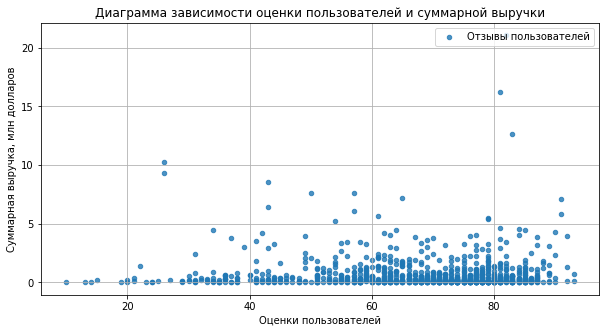

In [79]:
df_game_good_review[['platform', 'user_score','revenue']].plot(
        x = 'user_score', 
        y = 'revenue', 
        kind = 'scatter', 
        figsize = [10,5], 
        grid = True, 
        alpha = 0.8, 
        label = 'Отзывы пользователей',
        legend = True)
plt.title('Диаграмма зависимости оценки пользователей и суммарной выручки')
plt.legend(loc = 'upper right')
plt.ylabel('Суммарная выручка, млн долларов')
plt.xlabel('Оценки пользователей')
plt.show()

**Добавим диаграмму зависимости отзывов критиков и суммарной выручки за актуальный период по популярным платформам**

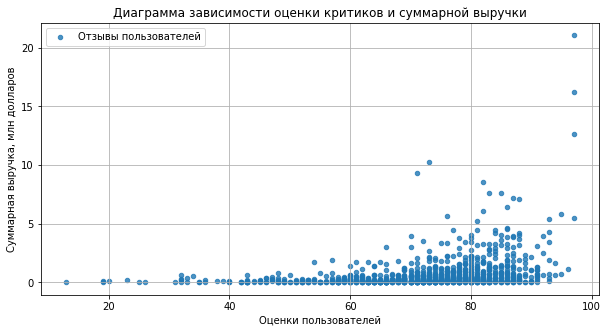

In [89]:
df_game_good_review[['platform', 'critic_score','revenue']].plot(
        x = 'critic_score', 
        y = 'revenue', 
        kind = 'scatter', 
        figsize = [10,5], 
        grid = True, 
        alpha = 0.8, 
        label = 'Отзывы пользователей',
        legend = True)
plt.title('Диаграмма зависимости оценки критиков и суммарной выручки')
plt.ylabel('Суммарная выручка, млн долларов')
plt.xlabel('Оценки пользователей')
plt.show()

**При первичном анализе графиков, можно отметить более выраженную линейную зависимость между оценкой критиков и суммарной выручкой. Для формирования более точных суждений вычислим коэффициент корреляции и посмотрим матрицу рассеяния**

In [87]:
# Посмотри корреляцию отзывов и выручки по популярным платформам в актуальный период

corr_list = ['user_score', 'critic_score']

for corr in corr_list:
    print('Корреляция между суммарной глобальной выручки и', corr, 'составляет', df_game_good_review[
        'revenue'].corr(df_game_good_review[corr]))

Корреляция между суммарной глобальной выручки и user_score составляет -0.003641546001396502
Корреляция между суммарной глобальной выручки и critic_score составляет 0.31177852717813076


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2332f410>,
      dtype=object)

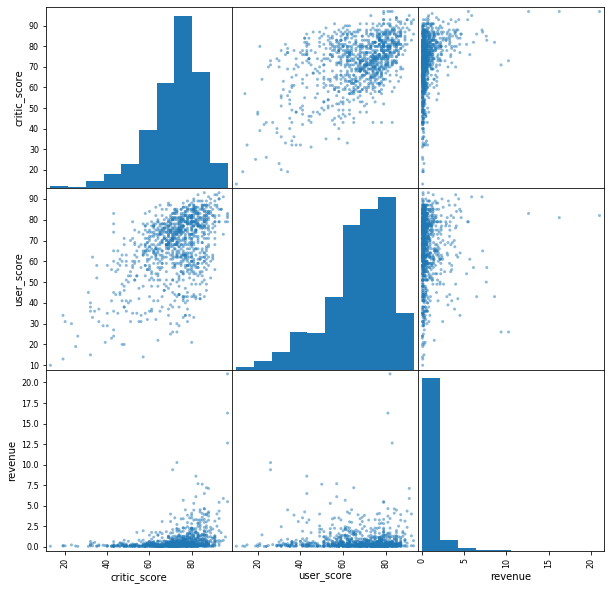

In [86]:
pd.plotting.scatter_matrix(df_game_good_review, figsize = [10, 10])

**Показатель корреляции отзывов пользователей и выручки равен 0, что говорит об отсуствии влияния оценки пользователя на продажи игр.**
    
**Показатель корреляции отзывов критиков и выручки равен 0,31, что говорит о слабой связи оценки критиков и объема продаж** 

**Следовательно не стоит опираться на оценки критиков и полтьзователей при подготовке кампании на 2017 год**</font>

Для более детального анализа зависимости оценки пользователей и критиков и их влияние на продажи в разрезе платформ, ниже подготовлены графики и рассчитаны коэффициенты корреляций в разрезе каждой платформы.

In [1]:
# Построим диаграммы рассеяния зависимости отзывов критиков и пользователей от выручки для каждой платформы

for platform in df_game_real_list:
    ax = df_game_good_review.loc[df_game_good_review['platform'] == platform].plot(
        x = 'user_score', 
        y = 'revenue', 
        kind = 'scatter', 
        figsize = [5,5], 
        grid = True, 
        alpha = 0.8, 
        label = 'Отзывы пользователей',
        legend = True)
    
    df_game_good_review.loc[df_game_good_review['platform'] == platform].plot(
         x = 'critic_score', 
        y = 'revenue', 
        kind = 'scatter', 
        figsize = [5,5], 
        grid = True, 
        ax=ax, 
        color = 'lightcoral', 
        alpha = 0.6, 
        label = 'Отзывы критиков',
        legend = True)
    plt.title(platform, loc = 'center')
    plt.legend(loc = 'upper right')
    plt.ylabel('Суммарная выручка в млн долларах')
    plt.xlabel('Оценки пользователей / критиков')
    plt.show()
    
# Посмотри корреляцию отзывов и выручки по популярным платформам в актуальный период в разрезе каждой платформы
    for corr in corr_list:
            print('Корреляция между суммарной глобальной выручкой платформы', platform, 'и', corr, 'составляет', 
            df_game_good_review.loc[(df_game_good_review['platform'] == platform)]['revenue'].
              corr(df_game_good_review[corr]))

NameError: name 'df_game_real_list' is not defined

Взаимосвязи **пользовательских рейтингов** и суммарной глобальной выручкой нет для всех платформ, кроме WiiU, PSV - для них есть довольно слабая зависимость между выручкой и пользовательскими рейтингами.

Взаимосвязи **рейтингов критиков** и суммарной глобальной выручкой очень слабые для платформ: PC и PSV, для всех остальных платформ данная зависимость очень слабая. 

Следовательно, можно сделать вывод, что оценки пользователей и оценки критиков не влияют на объем продаж игр.

Можно предположить, что одни из самых востребованных платформ по объемам продаж в 2017 году будут PS4 и XboxOne, и это связано с тем, что это актуальные консоли на 2016-2017 года, но также стоит учитывать консоли предыдущего поколения Xbox360 и PS3, также стабильность спроса показывает PC и небольшое уменьшение спроса на WiiU. Относительно портативной консоли 3DS - есть тенденция к уменьшению спроса, предположительно в 2017 году ожидается уменьшение спроса на игры данной консоли, относительно PSV - спрос стабилен, что ожидается и в 2017 году.

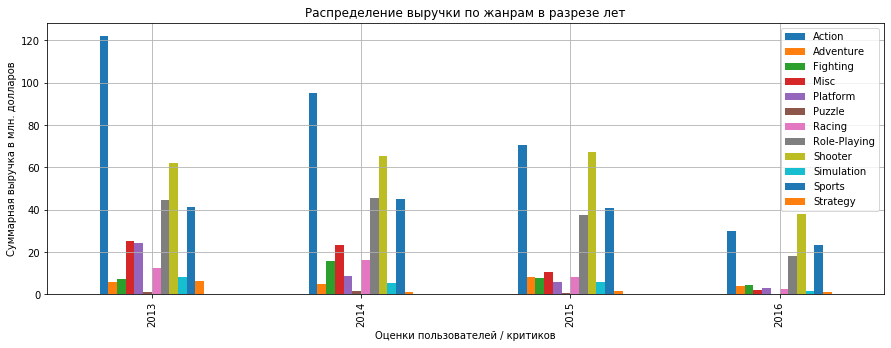

In [53]:
# Посмотрим на суммарную выручку по годам

df_genre_pivot = df_game_real.pivot_table(
    index = 'genre', columns = 'year_of_release', values = 'revenue', aggfunc = 'sum').T.plot(
    kind = 'bar',
    grid = True,
    figsize = [15,5])

plt.title('Распределение выручки по жанрам в разрезе лет')
plt.legend(loc = 'upper right')
plt.ylabel('Суммарная выручка в млн. долларов')
plt.xlabel('Оценки пользователей / критиков')
plt.show()

Жанры с самым высоким спросом в актуальный период это Action, Shooter, Sport и Role-Playing, важно учитывать, что спрос на игры жанра Action падает, тогда как на игры жанра Shooter прослеживается небольшой рост спроса. Становятся менее востребованными игры жанра Misc, Platform, Fighting. Спрос на игры жанра Adventure стабилен. 

В целом наблюдается тенденция к росту спроса и популярность соответсвенно Action, Shooter, Sport и Role-Playing, можно предположить, что именно эти жанры игр будут самые восстребованные в 2017 году.

### Выводы по EDA:
1. Был пик по выпуску игр в 2008 году, что обусловлено качественным скачком в gamedev индустрии.
2. Характерный период жизни платформы - 10 лет - это средний срок выпуска консоли нового поколения.
3. Определим актуальный период для анализа с 2013 по 2016 года, учитывая, что данные за 2016 год будут неполными.
4. На актуальные поколения платформ XOne и PS4 увеличивается спрос, на платформы прошлого поколения - уменьшается, PC, PSV, WiiU  - стабильный уровень спроса.
5. Пользовательские рейтинги не влияют на продажи, тогда как рейтинги критингов влияют слабое влияние на объем продаж
6. Жанры с самым высоким спросом в актуальный период это Action, Shooter, Sport и Role-Playing, набирает популярность жанр Shooter.
7. Медианные значения выручки по каждой из консоли приблизительно одинаковые, кроме портативных PSV, PС и 3DS. Значения 75 перцентиля намного выше медианных значений для каждой платформы, что обусловлено пиками в продажах.

### <a id="step4">Шаг 4. Составьте портрет пользователя каждого региона

#### Определим для каждого региона:
* Cамые популярные платформы (топ-5) в актуальный период
* Самые популярные жанры (топ-5).
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [54]:
# Возьмем нужные столбцы для анализа для актуального периода и самых востребованных платформ

df_game_regions = df_game_real_platform[['platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'rating']]
regions_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'] # список регионов

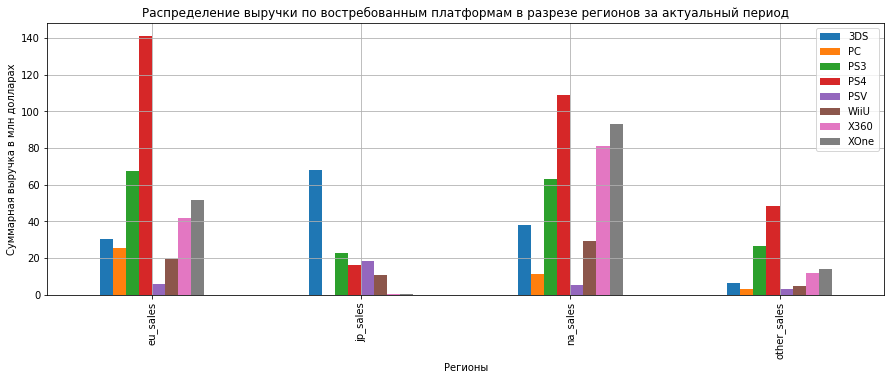

In [55]:
# Определим top-5 платформ для каждого региона

df_game_regions_pivot = (df_game_regions.pivot_table(
    index = 'platform', values = regions_list, aggfunc = 'sum')
    .T
    .plot(kind = 'bar', grid = True, figsize = [15,5]))

plt.title('Распределение выручки по востребованным платформам в разрезе регионов за актуальный период')
plt.legend(loc = 'upper right')
plt.ylabel('Суммарная выручка в млн долларах')
plt.xlabel('Регионы')
plt.show()

In [56]:
# Посмотрим топ-5 по каждому региону

for region in regions_list:   
    df_game_real_regions_pivot_2 = df_game_real.pivot_table( 
    index = 'platform', values = region, aggfunc = 'sum')
    print(df_game_real_regions_pivot_2.sort_values(by = region, ascending = False).head(5), '\n\n')

          na_sales
platform          
PS4        108.620
XOne        92.770
X360        80.900
PS3         63.270
3DS         37.710 


          eu_sales
platform          
PS4        141.090
PS3         67.230
XOne        51.430
X360        42.040
3DS         30.110 


          jp_sales
platform          
3DS         67.700
PS3         22.980
PSV         18.480
PS4         15.960
WiiU        10.880 


          other_sales
platform             
PS4            48.330
PS3            26.620
XOne           14.230
X360           11.990
3DS             6.180 




Топ-5 платформ по выручке во всех регионах одинаков, кроме Японии. Как и ожидалось, в Японии наиболее популярная платформа - Nintendo 3DS, при этом топ-1 в остальных регионах PS4, в Японии занимает только 4 место, уступая даже портативной консоле PSVita, которая во всех остальных регионах не входит в топ-5.
Стоит отметить, что в Северной Америке и Европе покупают игры на консоли чаще и выручка по каждой платформе больше в несколько раз, например, в других странах выручка от продаж игр на PS4 меньше в 3 раза относительно продаж в Европе и в 2 раза - относительно  Северной Америки

In [57]:
# Определим top-5 жанров для каждого региона

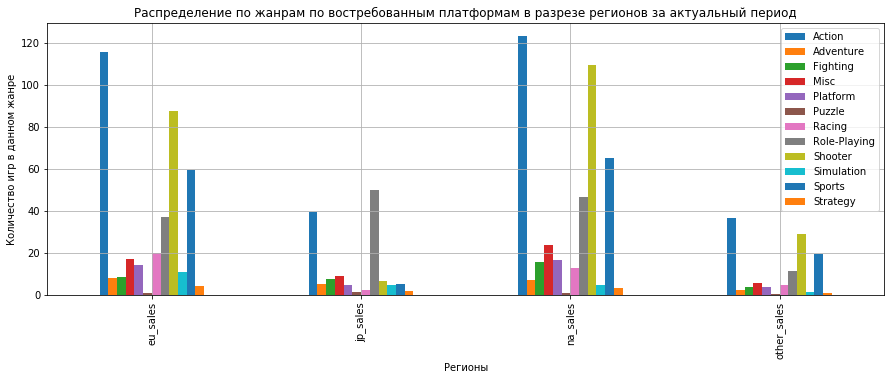

In [58]:
(df_game_regions.pivot_table(
    index = 'genre', values = regions_list, aggfunc = 'sum')
    .T
    .plot(kind = 'bar', grid = True, figsize = [15,5]))

plt.title('Распределение по жанрам по востребованным платформам в разрезе регионов за актуальный период')
plt.legend(loc = 'upper right')
plt.ylabel('Количество игр в данном жанре')
plt.xlabel('Регионы')
plt.show()

In [59]:
# Посмотрим топ-5 по каждому региону

for region in regions_list:   
    df_game_real_regions_pivot_3 = df_game_real.pivot_table( 
    index = 'genre', values = region, aggfunc = 'sum')
    print(df_game_real_regions_pivot_3.sort_values(by = region, ascending = False).head(5), '\n\n')

              na_sales
genre                 
Action         124.660
Shooter        109.610
Sports          65.170
Role-Playing    46.400
Misc            26.640 


              eu_sales
genre                 
Action         116.440
Shooter         87.720
Sports          60.220
Role-Playing    36.970
Racing          20.090 


              jp_sales
genre                 
Role-Playing    51.040
Action          40.020
Misc             9.200
Fighting         7.620
Shooter          6.600 


              other_sales
genre                    
Action             36.880
Shooter            28.760
Sports             19.410
Role-Playing       11.480
Misc                5.940 




Top-4 игр совпадает в регонах Северной Америки, Европы и других странах, 5 месте в Северной Америке и других странах - игры разных жанров Misc, а в Европе - Racing. В Японии другой рейтинг, топ-1 это role-playing, на втором Action.

### <a id="step6">Итоговые выводы

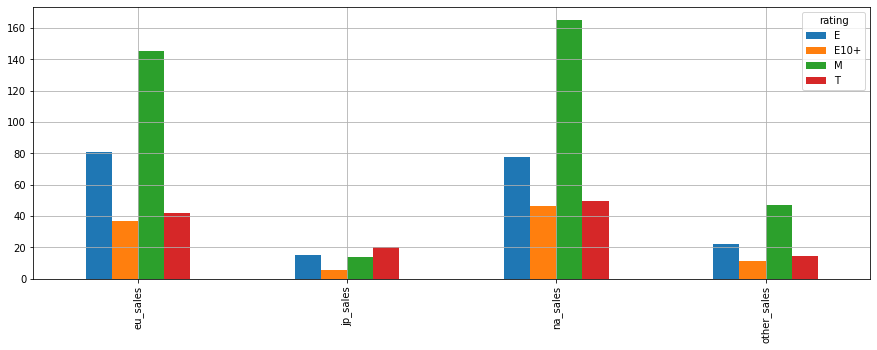

In [61]:
(df_game_regions.pivot_table(
    index = 'rating', values = regions_list, aggfunc = 'sum')
    .T
    .plot(kind = 'bar', grid = True, figsize = [15,5]))

#### Рейтинги ESRB: 
* E - Everyone
* E10+ - Everyone 10 and older
* T - Teen
* M - Mature

In [62]:
# Посмотрим распределение рейтингов по разным регионам

for region in regions_list:   
    df_game_real_regions_pivot_3 = df_game_real.pivot_table( 
    index = 'rating', values = region, aggfunc = 'sum')
    print(df_game_real_regions_pivot_3.sort_values(by = region, ascending = False).head(5), '\n\n')

        na_sales
rating          
M        165.150
E         78.240
E10+      51.970
T         49.600 


        eu_sales
rating          
M        145.300
E         82.030
T         41.810
E10+      40.030 


        jp_sales
rating          
T         20.120
E         15.140
M         14.110
E10+       5.760 


        other_sales
rating             
M            47.040
E            22.400
T            14.250
E10+         12.070 




Игры с рейтингом 17+ занимают первое место во всех регионах, кроме Японии, где лидирует рейтинг T. Интересно, что в Европе и Америке игры 17+ имеют выручку почти в 2 раза больше, чем игры с рейтингом T. Это связано с популярностью таких жанров, так Action и Shooter, которые практически всегда имеют рейтинг M, а в Японии популярны игры Role-playing, где уровень насилия ниже.

#### Выводы по разделу:
* Средний геймер из **Северной Америки** предпочитает игры на PS4 и XboxOne, при этом показатели продаж игра на XboxOne самый большой показатель относительно других регионов. Предпочитает игры в жанрах Action и Shooter, в связи с этим больше всего выручки у игр рейтинга M - 17+. Интересно, что на втором месте игры рейтинга E, в который входят игры жанра Sport (top-3 по жанрам в Северной Америке).
____
* Средний геймер из **европейских стран** предпочитает игры на PS4 и на PS3, игры на XboxOne и Xbox360 не так популярны, как в **Северной Америке**. По жанрам и рейтингу ситуация аналогичная с клиентами в **Северной Америке**. 
____
* Средний геймер **Японии** играет на платформе Nintendo3DS (во всех остальных регионах платформа занимает 5 место по выручке). Предпочтение по жанрам в **Японии** также отличается от других регионов: на первом месте Role-Playing игры, которым чаще всего присвоен рейтинг T 13+. Выручка в **Японии** на игры в разы меньше, чем в **Северной Америке и Европе**, что может обусловлено непопулярностью игр в **Японии**.
____
* Средний геймер из **других стран** предпочитает такие же жанры игр, как в **Европе и Северной Америке**, самые популярные консоли - PS4 и PS3, как в **европейских странах**, но по объемам выручки показатели ближе к показателям в **Японии**.

### <a id="step5">Шаг 5. Проверим гипотезы

**Гипотеза 1.** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

**Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

**Альтернативная гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC **не равны**

Для проверки гипотезы будем использовать критерий p-value

Критический уровень статистической значимости - 5 процентов.

*Выбор критерия Стьюдента обусловлен тем, что элементов выборки более 30 и выборки независимы*

In [63]:
sample1 = df_game_real_platform.loc[df_game_real_platform['platform'] == 'XOne']['user_score']
sample2 = df_game_real_platform.loc[df_game_real_platform['platform'] == 'PC']['user_score']
results = st.ttest_ind(sample1, sample2, nan_policy = 'omit')

alpha = 0.05

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.1401265840361139
Не получилось отвергнуть нулевую гипотезу


#### Полученное значение p-value позволяет сделать вывод, что средние пользовательские рейтинги платформ Xbox One и PC равны.

**Гипотеза 2.** Средние пользовательские рейтинги жанров Action и Sports разные.

**Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action и Sports **одинаковые**

**Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action и Sports **не равны**

Для проверки гипотезы будем использовать критерий p-value

Критический уровень статистической значимости - 5 процентов.

In [64]:
sample1 = df_game_real_platform.loc[df_game_real_platform['genre'] == 'Action']['user_score']
sample2 = df_game_real_platform.loc[df_game_real_platform['genre'] == 'Sports']['user_score']
results = st.ttest_ind(sample1, sample2, nan_policy = 'omit')

alpha = 0.05

print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергунуть нулевую гипотезу')

p-значение 4.172703051737009e-27
Отвергаем нулевую гипотезу


#### Полученное значение p-value настолько мало, что позволяет сделать вывод, что средние пользовательские рейтинги жанров Action и Sports разные.

### <a id="step6">Итоговые выводы:
    
1. Характерный срок жизни платформы 10 лет, кроме PC, так как он не зависит от выпуска новых поколений, как консоли. Как раз в 2015-2016 гг наблюдается спад спроса на консоли Xbox360 и PS3, и ростом популярности консолей нового поколения  XboxOne и PS4.
2. В 2017 году ожидается возрастающая популярность игра для консолей актуального поколения PS4 и XboxOne, но также стоит учитывать консоли предыдущего поколения Xbox360 и PS3. Также стабильность спроса характерна для игр на PC и небольшое уменьшение спроса на WiiU, что ожидается и в 2017 году. Относительно портативной консоли 3DS - есть тенденция к уменьшению спроса, но это самая востребованная платформа в Японии, относительно PSV - спрос стабилен.
3. В 2017 году ожидается популярность жанров Shooter, Action, Sport (Северная Америка, Европа и другие страны) и Role-Playing (Япония). 
4. Следует ожидать, что в 2017 будут популярны игры с рейтингом M 17+ по системе ESRB. 
5. Покупатели из Северной Америки и Европы готовы больше тратить денег на игры, чем покупатели из других стран и Японии
6. Пользовательские рейтинги практически не влияют на выручку по продажам игр, рейтинги критиков имеют слабое влияние на выручку. Таким образом на рейтинги при прогнозировании ассортимента магазина на 2017 год не стоит.    